In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch, Sbopen
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Importing the Dataset

In [3]:
# open dataset from Statsbomb
parser = Sbopen()

In [5]:
competitions = parser.competition()

In [7]:
competitions.head()

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,281,Germany,1. Bundesliga,male,False,False,2023/2024,2024-05-21T03:36:44.090970,2024-05-21T03:38:27.534702,2024-05-21T03:38:27.534702,2024-05-21T03:36:44.090970
1,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2024-05-19T11:11:14.192381,None,None,2024-05-19T11:11:14.192381
2,1267,107,Africa,African Cup of Nations,male,False,True,2023,2024-02-28T18:02:23.493027,None,None,2024-02-28T18:02:23.493027
3,16,4,Europe,Champions League,male,False,False,2018/2019,2024-05-13T13:14:25.239651,2021-06-13T16:17:31.694,None,2024-05-13T13:14:25.239651
4,16,1,Europe,Champions League,male,False,False,2017/2018,2024-02-13T02:35:28.134882,2021-06-13T16:17:31.694,None,2024-02-13T02:35:28.134882


In [11]:
matches = parser.match(competition_id=9, season_id=281)
# all matches Statsbomb provided are Bayer Leverkusen's match

In [12]:
matches.columns

Index(['match_id', 'match_date', 'kick_off', 'home_score', 'away_score',
       'match_status', 'match_status_360', 'last_updated', 'last_updated_360',
       'match_week', 'competition_id', 'country_name', 'competition_name',
       'season_id', 'season_name', 'home_team_id', 'home_team_name',
       'home_team_gender', 'home_team_group', 'home_team_country_id',
       'home_team_country_name', 'home_team_managers_id',
       'home_team_managers_name', 'home_team_managers_nickname',
       'home_team_managers_dob', 'home_team_managers_country_id',
       'home_team_managers_country_name', 'away_team_id', 'away_team_name',
       'away_team_gender', 'away_team_group', 'away_team_country_id',
       'away_team_country_name', 'away_team_managers_id',
       'away_team_managers_name', 'away_team_managers_nickname',
       'away_team_managers_dob', 'away_team_managers_country_id',
       'away_team_managers_country_name', 'metadata_data_version',
       'metadata_shot_fidelity_version', 'm

# Preparing the dataset
1. Get all Leverkusen's passes data from each match, then stack them
2. Filter out passes out of field / corners / Throw-ins 
3. Classify progressive passes

In [15]:
lev_pass = pd.DataFrame(columns=['x','y','end_x','end_y','pass_length','pass_angle','pass_height_name'])

A pass is considered progressive if the distance between the starting point and the next touch is:

at least 30 meters closer to the opponent’s goal if the starting and finishing points are within a team’s own half
at least 15 meters closer to the opponent’s goal if the starting and finishing points are in different halves
at least 10 meters closer to the opponent’s goal if the starting and finishing points are in the opponent’s half

In [53]:
# stack all Leverkusen's passes
lev_pass = pd.DataFrame(columns=[
    'x', 'y', 'end_x', 'end_y', 'pass_length', 'pass_angle', 'pass_height_name'
])
for match_id in matches['match_id']:
    event, related, freeze, tactics = parser.event(match_id)
    pass_df = event.loc[(event['team_name'] == 'Bayer Leverkusen')
                        & (event['type_name'] == 'Pass')][[
                            'x', 'y', 'end_x', 'end_y', 'sub_type_name',
                            'pass_length', 'pass_angle', 'pass_height_name',
                            'outcome_name'
                        ]]
    lev_pass = lev_pass._append(pass_df, ignore_index=True)

In [54]:
lev_pass

,x,y,end_x,end_y,pass_length,pass_angle,pass_height_name,sub_type_name,outcome_name
0,33.3,43.2,8.5,33.8,26.521688,-2.779292,Ground Pass,Interception,NaN
1,8.5,33.8,15.1,21.5,13.958868,-1.078311,Ground Pass,NaN,NaN
2,22.3,19.5,38.1,19.5,15.800000,0.000000,Ground Pass,NaN,NaN
3,38.1,19.5,29.9,19.5,8.200000,3.141593,Ground Pass,NaN,NaN
4,48.1,28.6,48.6,49.7,21.105923,1.547104,Ground Pass,NaN,NaN
...,...,...,...,...,...,...,...,...,...
24239,105.1,74.0,112.3,77.0,7.800000,0.394791,Ground Pass,NaN,NaN
24240,117.9,79.5,117.5,76.1,3.423449,-1.687905,Low Pass,NaN,Incomplete
24241,120.0,80.0,116.4,77.0,4.686150,-2.446854,Ground Pass,Corner,NaN
24242,92.0,12.8,96.5,22.4,10.602358,1.132460,Ground Pass,NaN,Incomplete


In [55]:
# Only OpenPlay build-up passes
lev_pass.sub_type_name.unique()

array(['Interception', nan, 'Recovery', 'Free Kick', 'Corner', 'Throw-in',
       'Goal Kick', 'Kick Off'], dtype=object)

In [64]:
# Filter
lev_pass_openplay = lev_pass.loc[
    (lev_pass['sub_type_name'].isna()) & (lev_pass['outcome_name'] != 'Out') &
    (lev_pass['outcome_name'] != 'Unknown') &
    (lev_pass['outcome_name'] != 'Injury Clearance')]

In [75]:
# Label outcome as Complete/Incomplete(Offside & Incomplete)
lev_pass_openplay['outcome_name'] = lev_pass_openplay['outcome_name'].apply(
    lambda x: 'Complete' if pd.isna(x) else 'Incomplete')

In [76]:
lev_pass_openplay

,x,y,end_x,end_y,pass_length,pass_angle,pass_height_name,sub_type_name,outcome_name
1,8.5,33.8,15.1,21.5,13.958868,-1.078311,Ground Pass,NaN,Complete
2,22.3,19.5,38.1,19.5,15.800000,0.000000,Ground Pass,NaN,Complete
3,38.1,19.5,29.9,19.5,8.200000,3.141593,Ground Pass,NaN,Complete
4,48.1,28.6,48.6,49.7,21.105923,1.547104,Ground Pass,NaN,Complete
5,54.5,54.3,56.4,66.1,11.951987,1.411150,Ground Pass,NaN,Complete
...,...,...,...,...,...,...,...,...,...
24238,117.5,71.4,105.5,74.2,12.322337,2.912361,Ground Pass,NaN,Complete
24239,105.1,74.0,112.3,77.0,7.800000,0.394791,Ground Pass,NaN,Complete
24240,117.9,79.5,117.5,76.1,3.423449,-1.687905,Low Pass,NaN,Incomplete
24242,92.0,12.8,96.5,22.4,10.602358,1.132460,Ground Pass,NaN,Incomplete


## Classify progressive passes
A pass is defined as progressive if:
- The distance between the starting point and the next touch is:
    - at least 30 meters closer to the opponent’s goal if the starting and finishing points are within a team’s own half
    - at least 15 meters closer to the opponent’s goal if the starting and finishing points are in different halves
    - at least 10 meters closer to the opponent’s goal if the starting and finishing points are in the opponent’s half
- Any pass into the opponent’s penalty area

> An integration of FBref & Wyscout's definitions

In [83]:
def is_progressive(x, y, end_x, end_y):
    closer = end_x - x
    if end_x > 163.5 and end_y > 19.84 and end_y < 60.16:  # into penalty area
        return True
    elif x <= 90 and end_x <= 90 and closer >= 30:  # own half
        return True
    elif x <= 90 and end_x > 90 and closer >= 15:  # different half
        return True
    elif x > 90 and end_x > 90 and closer >= 10:  # opponent's half
        return True
    else:
        return False

In [84]:
lev_pass_openplay['is_progressive'] = lev_pass_openplay.apply(
    lambda row: is_progressive(row.x, row.y, row.end_x, row.end_y), axis=1)

In [86]:
lev_pass_openplay.groupby('is_progressive').count()

,x,y,end_x,end_y,pass_length,pass_angle,pass_height_name,sub_type_name,outcome_name
is_progressive,,,,,,,,,
False,19374,19374,19374,19374,19374,19374,19374,0,19374
True,1708,1708,1708,1708,1708,1708,1708,0,1708


In [88]:
lev_prog = lev_pass_openplay[lev_pass_openplay['is_progressive'] == True]

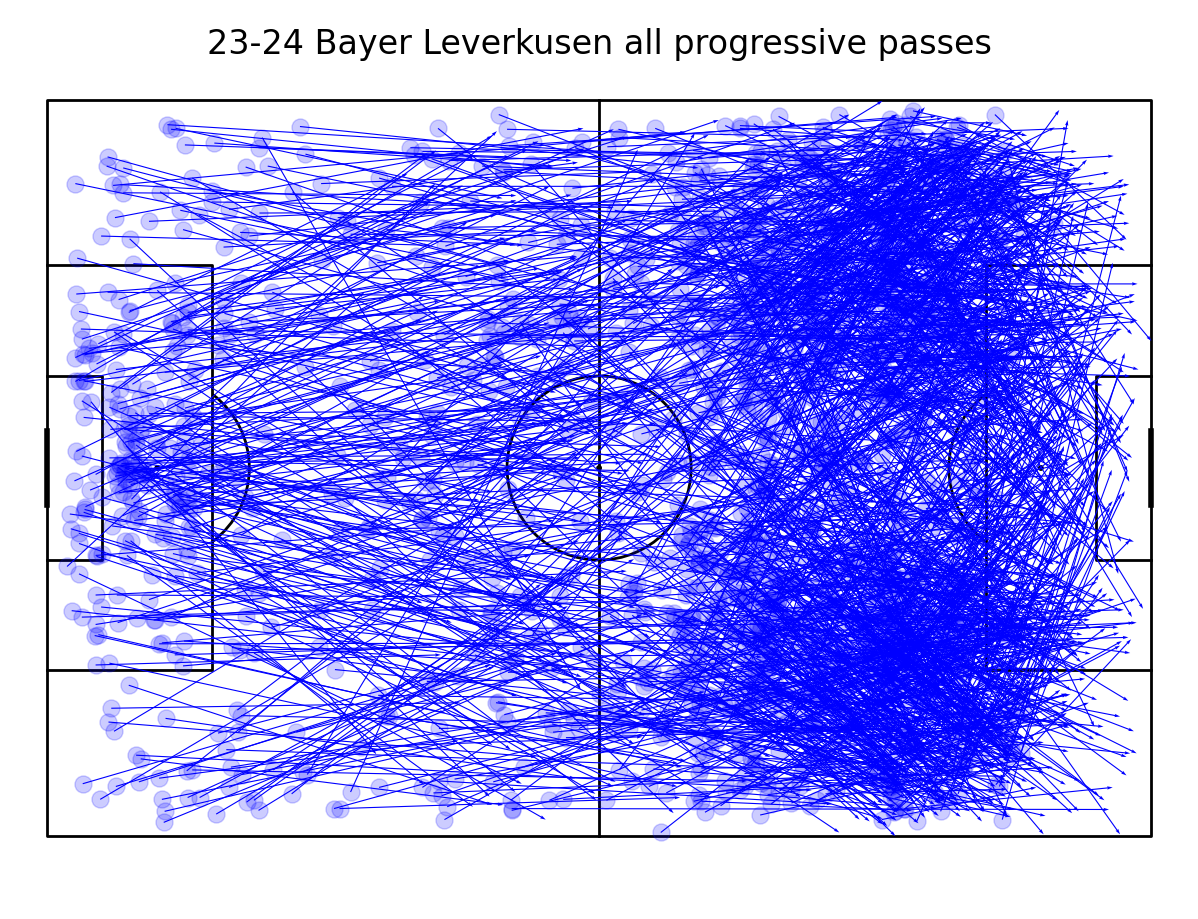

In [91]:
pitch = Pitch('statsbomb', line_color='black')
fig, ax = pitch.grid(grid_height=0.9,
                     title_height=0.06,
                     axis=False,
                     endnote_height=0.04,
                     title_space=0,
                     endnote_space=0)

pitch.arrows(lev_prog.x,
             lev_prog.y,
             lev_prog.end_x,
             lev_prog.end_y,
             color='blue',
             ax=ax['pitch'],
             width=0.8)
pitch.scatter(lev_prog.x,
              lev_prog.y,
              alpha=0.2,
              s=150,
              color='blue',
              ax=ax['pitch'])
fig.suptitle("23-24 Bayer Leverkusen all progressive passes", fontsize=24)
plt.show()

# Clustering Progressive Passes
- KMeans Algorithm
- Elbow method to find the optimal clustering number

In [92]:
from sklearn.cluster import KMeans

def k_means_clustering(data, num_clusters):

    kmeans = KMeans(n_clusters=num_clusters, random_state=1)
    labels = kmeans.fit_predict(data)
    
    return labels

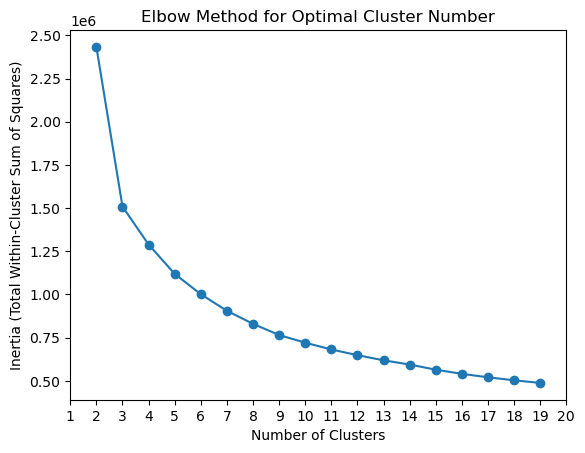

In [94]:
data = lev_prog[['x', 'y', 'end_x', 'end_y', 'pass_length', 'pass_angle']]
cluster_range = range(2, 20, 1)
inertia_values = []

for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=1)
    kmeans.fit(data)
    inertia_values.append(kmeans.inertia_)

# elbow method plot
plt.plot(cluster_range, inertia_values, marker='o')
plt.title('Elbow Method for Optimal Cluster Number')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Total Within-Cluster Sum of Squares)')
plt.xticks(np.linspace(1, 20, 20))
plt.show()

In [98]:
# n=9
num_clusters = 9
# cluster
cluster_labels = k_means_clustering(data, num_clusters)

# label
lev_prog['cluster'] = cluster_labels

# print cluster means
cluster_means = lev_prog.groupby('cluster')[[
    'x', 'y', 'end_x', 'end_y', 'pass_length', 'pass_angle'
]].mean()

print("cluster mean：")
cluster_means

cluster mean：


,x,y,end_x,end_y,pass_length,pass_angle
cluster,,,,,,
0,12.975658,28.369737,57.671053,21.478289,47.612894,-0.136087
1,88.274439,27.479821,107.211659,35.590583,24.554809,0.297689
2,15.271141,53.901342,61.933557,59.287248,50.361869,0.107042
3,69.073859,60.765560,96.103320,67.166805,30.829690,0.263862
4,48.913386,26.303150,92.241732,15.439370,48.001232,-0.240222
5,90.414642,60.014953,107.269470,59.503115,20.463974,0.006157
6,81.873874,58.090991,106.586486,23.507207,44.136330,-0.934101
7,84.545223,17.012420,103.621019,12.061465,22.620463,-0.212232
8,61.398571,26.255714,101.331429,59.497143,55.173209,0.700026


In [133]:
cluster_means.loc[[0]]

,x,y,end_x,end_y,pass_length,pass_angle
cluster,,,,,,
0,12.975658,28.369737,57.671053,21.478289,47.612894,-0.136087


# Visualize the result
- Mark incomplete passes

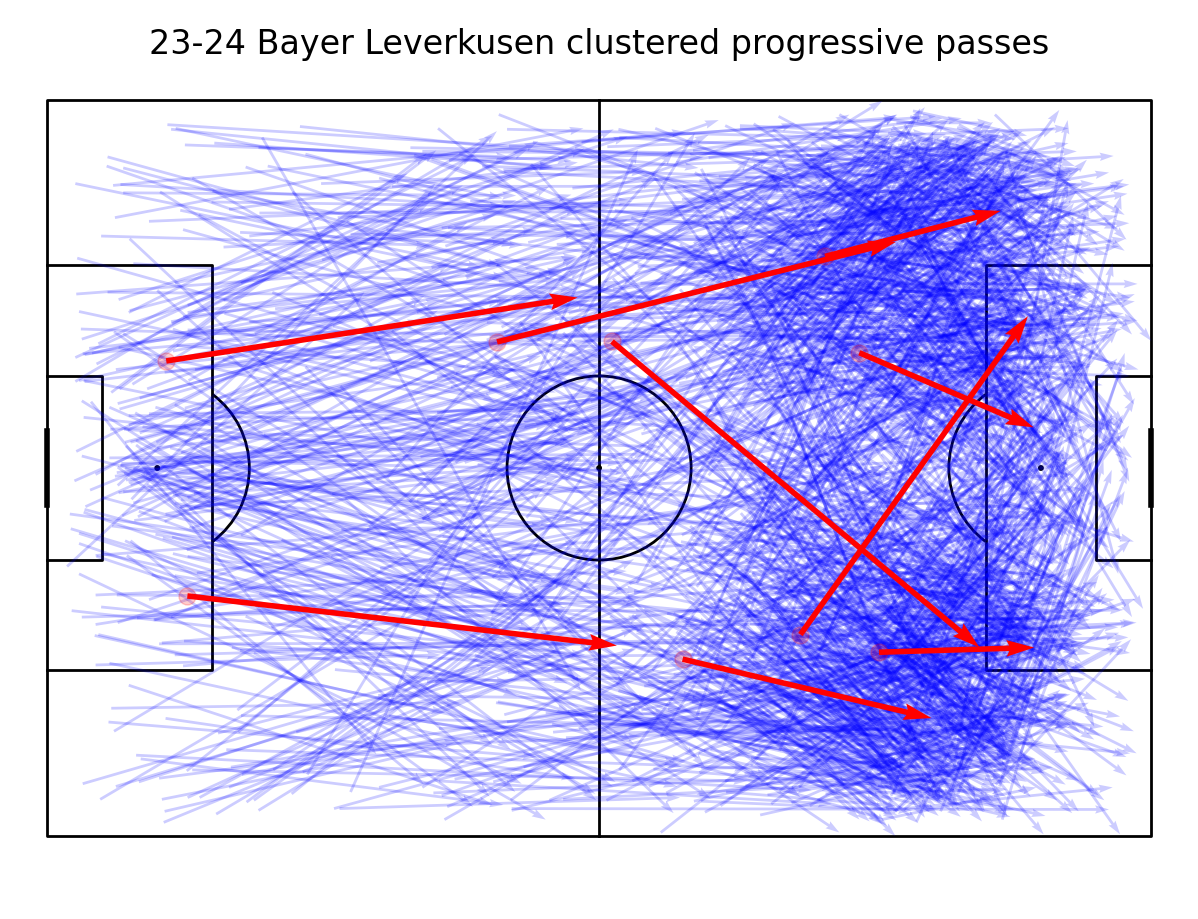

In [99]:
pitch = Pitch('statsbomb', line_color='black')
fig, ax = pitch.grid(grid_height=0.9,
                     title_height=0.06,
                     axis=False,
                     endnote_height=0.04,
                     title_space=0,
                     endnote_space=0)

pitch.arrows(lev_prog.x,
             lev_prog.y,
             lev_prog.end_x,
             lev_prog.end_y,
             color='blue',
             ax=ax['pitch'],
             alpha=0.2,
             width=2)
pitch.arrows(cluster_means.x,
             cluster_means.y,
             cluster_means.end_x,
             cluster_means.end_y,
             color='red',
             ax=ax['pitch'],
             alpha=1,
             width=4)
pitch.scatter(cluster_means.x,
              cluster_means.y,
              alpha=0.2,
              s=150,
              color='red',
              ax=ax['pitch'])
fig.suptitle("23-24 Bayer Leverkusen clustered progressive passes",
             fontsize=24)
plt.show()

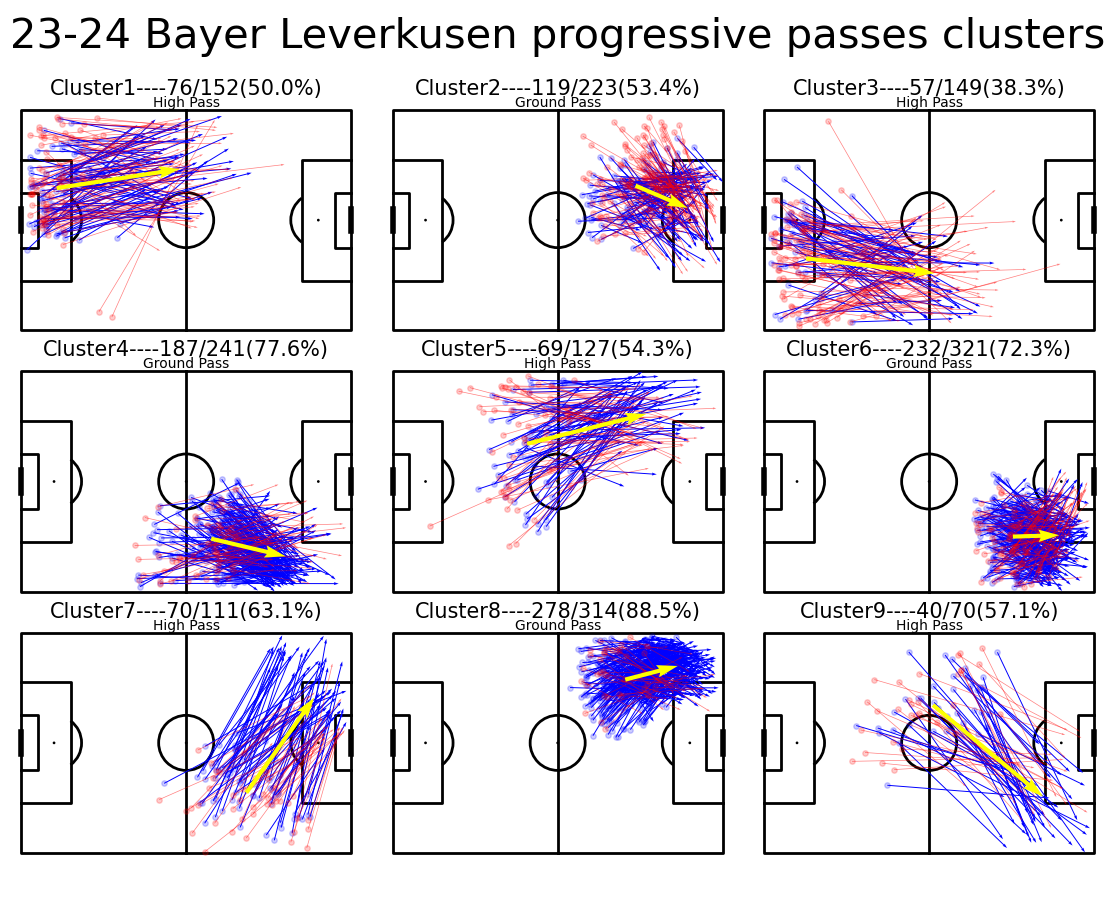

In [163]:
pitch = Pitch('statsbomb', line_color='black')
dpi = 800
fig, axs = pitch.grid(ncols=3,
                      nrows=3,
                      grid_height=0.85,
                      title_height=0.06,
                      axis=False,
                      endnote_height=0.04,
                      title_space=0.04,
                      endnote_space=0.01)

# for each pass cluster
for clust, ax in zip(np.linspace(0, num_clusters - 1, num_clusters),
                     axs['pitch'].flat[:num_clusters]):
    # take only passes by this cluster
    clustered = lev_prog.loc[lev_prog['cluster'] == clust]
    # scatter
    correct = clustered.loc[clustered['outcome_name'] == 'Complete']
    pitch.scatter(correct.x, correct.y, alpha=0.2, s=15, color="blue", ax=ax)
    # plot arrow
    pitch.arrows(correct.x,
                 correct.y,
                 correct.end_x,
                 correct.end_y,
                 color="blue",
                 ax=ax,
                 width=0.7)
    incorrect = clustered.loc[clustered['outcome_name'] == 'Incomplete']
    pitch.scatter(incorrect.x,
                  incorrect.y,
                  alpha=0.2,
                  s=15,
                  color="red",
                  ax=ax)
    # plot arrow
    pitch.arrows(incorrect.x,
                 incorrect.y,
                 incorrect.end_x,
                 incorrect.end_y,
                 color="red",
                 ax=ax,
                 width=0.5,
                 alpha=0.5)

    # put cluster name and completion rate over the plot
    ax.text(60,
            -8,
            'Cluster' + str(int(clust + 1)) + '----' +
            f'{correct.shape[0]}/{clustered.shape[0]}' +
            f'({np.round(correct.shape[0]*100/clustered.shape[0],1)}%)',
            ha='center',
            va='center',
            fontsize=15)
    # plot mean passing path
    mean = cluster_means.loc[clust]
    pitch.arrows(mean.x,
                 mean.y,
                 mean.end_x,
                 mean.end_y,
                 color='yellow',
                 ax=ax,
                 alpha=1,
                 width=3)

    # put the most common pass height under the plot
    most_common_pass_type = lev_prog.groupby('cluster')[
        'pass_height_name'].agg(lambda x: x.value_counts().idxmax()).loc[clust]
    ax.text(60,
            -3,
            f'{most_common_pass_type}',
            ha='center',
            va='center',
            fontsize=10)

axs['title'].text(0.5,
                  0.5,
                  '23-24 Bayer Leverkusen progressive passes clusters',
                  ha='center',
                  va='center',
                  fontsize=30)
plt.show()
fig.savefig('23-24 Bayer Leverkusen progressive passes clusters.png', dpi=dpi)